In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [58]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Classroom/Assignment 5 Dataset.zip" -d "./gdrive/My Drive"

Streaming output truncated to the last 5000 lines.
  inflating: ./gdrive/My Drive/Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: ./gdrive/My Drive/Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: ./gdrive/My Drive/Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: ./gdrive/My Drive/Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: ./gdrive/My Drive/Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: ./gdrive/My Drive/Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: ./gdrive/My Drive/Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: ./gdrive/My Drive/Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: ./gdrive/My Drive/Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-8

In [0]:
data_dir = '/content/gdrive/My Drive/Assignment 5 Dataset'

In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224, scale = (0.8, 1.0)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=200, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [0]:
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=200, shuffle=True)

In [0]:
train_data.shape

AttributeError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


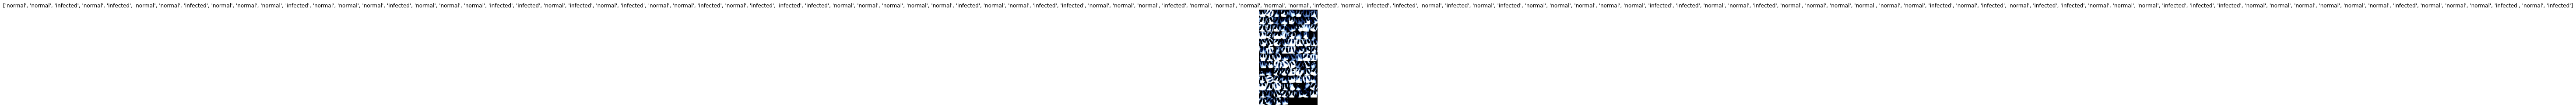

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

**Task 1 VGG16**

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [0]:
roll_formula = (69 * 10) + 100
features = list()
features.extend([nn.Linear(25088, roll_formula)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout()])

In [0]:
features.extend([nn.Linear(roll_formula, len(class_names))])

In [21]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [23]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
from tqdm import tqdm


vgg16.to(device)

vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')

print('Finished Training')

Train Epoch: 0 [11800/12000 (98%)]	Loss: 0.307279: : 60it [07:10,  7.17s/it]
Train Epoch: 1 [11800/12000 (98%)]	Loss: 0.214318: : 60it [07:08,  7.14s/it]
Train Epoch: 2 [11800/12000 (98%)]	Loss: 0.214475: : 60it [07:10,  7.17s/it]
Train Epoch: 3 [11800/12000 (98%)]	Loss: 0.224677: : 60it [07:10,  7.18s/it]
Train Epoch: 4 [11800/12000 (98%)]	Loss: 0.170664: : 60it [07:11,  7.19s/it]

Finished Training


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

NameError: ignored

In [25]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal infected infected infected normal normal infected normal normal infected normal infected normal normal normal normal infected normal infected normal infected normal infected normal infected infected normal normal normal infected normal normal normal normal infected normal normal normal normal normal infected infected infected infected infected normal infected normal normal infected infected infected normal normal normal normal normal infected normal normal infected normal normal normal infected normal normal normal normal normal infected normal normal infected normal normal normal normal normal normal infected infected infected infected normal infected infected infected normal normal infected normal normal infected normal normal normal normal infected
Ground Truth:  normal infected infected infected normal normal normal infected infected infected normal infected infected infected normal normal normal infected infected normal infected normal normal infected inf

In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 94 %


In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 87 %


**Test accuracy confusion matrix**

In [33]:
from sklearn.metrics import confusion_matrix

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)


[[536  79]
 [ 19 866]]
[87.15447154 97.85310734]


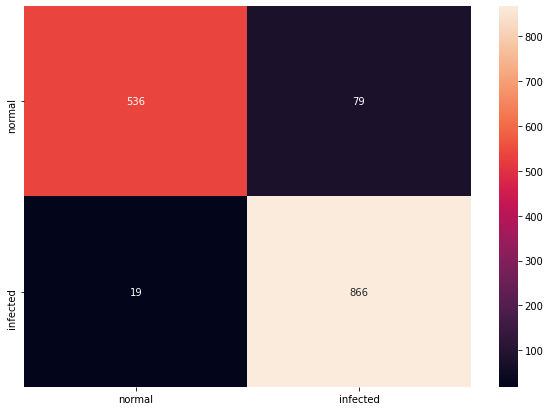

In [38]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(conf_mat, index = ["normal", "infected"],
                  columns = ["normal", "infected"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

**validation confusion matrix**

In [39]:

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(validationloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[495 120]
 [ 69 816]]
[80.48780488 92.20338983]


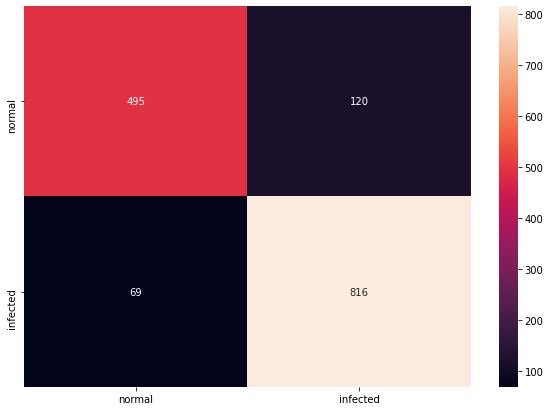

In [40]:

df_cm = pd.DataFrame(conf_mat, index = ["normal", "infected"],
                  columns = ["normal", "infected"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

**task 2 VGG-16**

In [41]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [0]:
# UnFreeze every 5th layer
for param in vgg16.features[5].parameters():
    param.requires_grad = True
for param in vgg16.features[10].parameters():
    param.requires_grad = True
for param in vgg16.features[True].parameters():
    param.requires_grad = True
for param in vgg16.features[True].parameters():
    param.requires_grad = True
for param in vgg16.features[True].parameters():
    param.requires_grad = True

In [0]:
#REMOVE LAST LAYER
vggFeatures = list(vgg16.classifier.children())[:-1]

In [0]:
roll_formula = (69 * 10) + 100
features = list()
features.extend([nn.Linear(4096, roll_formula)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Linear(roll_formula, len(class_names))])

In [0]:
vggFeatures.extend(features)

In [55]:
vgg16.classifier = nn.Sequential(*vggFeatures)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [60]:
from tqdm import tqdm


vgg16.to(device)

vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')

print('Finished Training')



0it [00:00, ?it/s]

Train Epoch: 0 [0/12000 (0%)]	Loss: 0.572222: : 0it [00:16, ?it/s]

Train Epoch: 0 [0/12000 (0%)]	Loss: 0.572222: : 1it [00:16, 16.24s/it]

Train Epoch: 0 [200/12000 (2%)]	Loss: 0.534440: : 1it [00:32, 16.24s/it]

Train Epoch: 0 [200/12000 (2%)]	Loss: 0.534440: : 2it [00:32, 16.39s/it]

Train Epoch: 0 [400/12000 (3%)]	Loss: 0.528144: : 2it [00:48, 16.39s/it]

Train Epoch: 0 [400/12000 (3%)]	Loss: 0.528144: : 3it [00:48, 16.27s/it]

Train Epoch: 0 [600/12000 (5%)]	Loss: 0.520149: : 3it [01:05, 16.27s/it]

Train Epoch: 0 [600/12000 (5%)]	Loss: 0.520149: : 4it [01:05, 16.37s/it]

Train Epoch: 0 [800/12000 (7%)]	Loss: 0.551173: : 4it [01:24, 16.37s/it]

Train Epoch: 0 [800/12000 (7%)]	Loss: 0.551173: : 5it [01:24, 17.21s/it]

Train Epoch: 0 [1000/12000 (8%)]	Loss: 0.524123: : 5it [01:41, 17.21s/it]

Train Epoch: 0 [1000/12000 (8%)]	Loss: 0.524123: : 6it [01:41, 17.14s/it]

Train Epoch: 0 [1200/12000 (10%)]	Loss: 0.502449: : 6it [01:58, 17.14s/it]

Train Epoch: 0 [1200

Finished Training


In [61]:
from sklearn.metrics import confusion_matrix

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)


[[550  65]
 [ 25 860]]
[89.43089431 97.17514124]


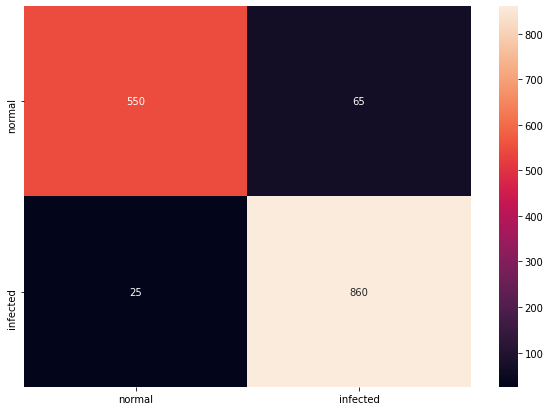

In [62]:

df_cm = pd.DataFrame(conf_mat, index = ["normal", "infected"],
                  columns = ["normal", "infected"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

In [63]:
from sklearn.metrics import confusion_matrix

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(validationloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)


[[517  98]
 [ 85 800]]
[84.06504065 90.39548023]


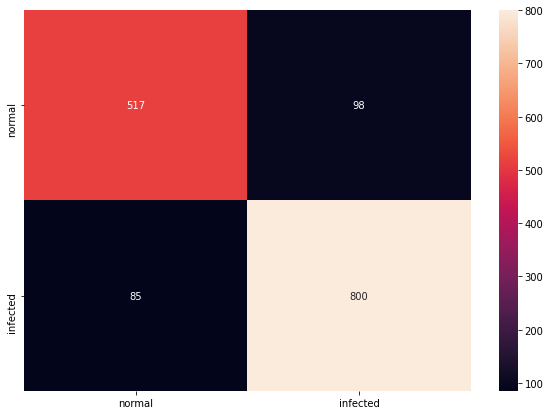

In [64]:

df_cm = pd.DataFrame(conf_mat, index = ["normal", "infected"],
                  columns = ["normal", "infected"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

In [65]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [0]:
# freezing layers
for param in resnet18.parameters():
    param.requires_grad = False

In [67]:
resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [0]:
# updating resnet fc layer
roll_formula = (69 * 10) + 100
resnet18.fc = nn.Sequential(
    nn.Linear(512, roll_formula),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(roll_formula, 2)
)

In [69]:
resnet18.fc

Sequential(
  (0): Linear(in_features=512, out_features=790, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=790, out_features=2, bias=True)
)

In [0]:
# freezing layers
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [0]:
Epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [72]:
from tqdm import tqdm


resnet18.to(device)

resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(resnet18.state_dict(), 'vgg16_ft.pth')

print('Finished Training')



0it [00:00, ?it/s]

Train Epoch: 0 [0/12000 (0%)]	Loss: 0.676043: : 0it [00:05, ?it/s]

Train Epoch: 0 [0/12000 (0%)]	Loss: 0.676043: : 1it [00:05,  5.39s/it]

Train Epoch: 0 [200/12000 (2%)]	Loss: 0.701656: : 1it [00:10,  5.39s/it]

Train Epoch: 0 [200/12000 (2%)]	Loss: 0.701656: : 2it [00:10,  5.45s/it]

Train Epoch: 0 [400/12000 (3%)]	Loss: 0.696519: : 2it [00:16,  5.45s/it]

Train Epoch: 0 [400/12000 (3%)]	Loss: 0.696519: : 3it [00:16,  5.47s/it]

Train Epoch: 0 [600/12000 (5%)]	Loss: 0.686422: : 3it [00:21,  5.47s/it]

Train Epoch: 0 [600/12000 (5%)]	Loss: 0.686422: : 4it [00:21,  5.42s/it]

Train Epoch: 0 [800/12000 (7%)]	Loss: 0.686537: : 4it [00:27,  5.42s/it]

Train Epoch: 0 [800/12000 (7%)]	Loss: 0.686537: : 5it [00:27,  5.42s/it]

Train Epoch: 0 [1000/12000 (8%)]	Loss: 0.659798: : 5it [00:32,  5.42s/it]

Train Epoch: 0 [1000/12000 (8%)]	Loss: 0.659798: : 6it [00:32,  5.44s/it]

KeyboardInterrupt: ignored

In [0]:

from sklearn.metrics import confusion_matrix

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

In [0]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(conf_mat, index = ["normal", "infected"],
                  columns = ["normal", "infected"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

In [0]:

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(validationloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

In [0]:
df_cm = pd.DataFrame(conf_mat, index = ["normal", "infected"],
                  columns = ["normal", "infected"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

**task2- resnet**

In [0]:
# Load the pretrained model from pytorch
resnet18_2 = models.resnet18(pretrained=True)
print(resnet18_2)

In [0]:
# freezing layers just 1st and 3rd layer
for param in resnet18_2.layer1.parameters():
    param.requires_grad = False
for param in resnet18_2.layer3.parameters():
    param.requires_grad = False

In [0]:
# updating resnet fc layer
roll_formula = (69 * 10) + 100
resnet18_2.fc = nn.Sequential(
    nn.Linear(512, 1000),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(1000, roll_formula),
    nn.ReLU(inplace=True),
    nn.Linear(roll_formula, 2)
)

In [0]:
resnet18_2.fc

In [0]:
# freezing layers
for param in resnet18_2.fc.parameters():
    param.requires_grad = True

In [0]:
Epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_2.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm


resnet18_2.to(device)

resnet18_2.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs = resnet18_2(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(resnet18_2.state_dict(), 'vgg16_ft.pth')

print('Finished Training')

In [0]:

from sklearn.metrics import confusion_matrix

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18_2(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

In [0]:
df_cm = pd.DataFrame(conf_mat, index = ["normal", "infected"],
                  columns = ["normal", "infected"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

In [0]:

from sklearn.metrics import confusion_matrix

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18_2(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

In [0]:
df_cm = pd.DataFrame(conf_mat, index = ["normal", "infected"],
                  columns = ["normal", "infected"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')